Exploring with PCA
===

<div class="alert alert-block alert-info"> 
Author: Nathan A. Mahynski

Date: 2023/08/23

Description: Illustrate modeling with Principal Components Analysis (PCA).
</div>

In [1]:
using_colab = 'google.colab' in str(get_ipython())
if using_colab:
    !git clone https://github.com/mahynski/pychemauth.git --depth 1
    !cd pychemauth; pip3 install .; cd ..

try:
    import pychemauth
except:
    raise ImportError("pychemauth not installed")

import matplotlib.pyplot as plt
%matplotlib inline

import watermark
%load_ext watermark

%load_ext autoreload
%autoreload 2

In [2]:
import sklearn

import numpy as np
import pandas as pd

from pychemauth.classifier.pca import PCA

In [3]:
%watermark -t -m -v --iversions

Python implementation: CPython
Python version       : 3.11.4
IPython version      : 8.14.0

Compiler    : GCC 12.2.0
OS          : Linux
Release     : 6.2.0-26-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 40
Architecture: 64bit

watermark : 2.4.3
pychemauth: 0.0.0b3
sklearn   : 1.3.0
numpy     : 1.24.4
pandas    : 2.0.3
json      : 2.0.9
matplotlib: 3.7.2



Some Utilities for Later
---

In [4]:
def plot_extremes(X, upper_frac=0.25):
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12,8))

    for ax, n_components in zip(axes.ravel(), [1, 2, 3, 4, 6, 10]):
        model = PCA(
            n_components=n_components, 
            alpha=0.05, 
            gamma=0.01, 
            scale_x=True, # PCA always centers, but you can choose whether or not to scale the columns by st. dev. (autoscaling)
            robust="semi" # Estimate the degrees of freedom for the chi-squared acceptance area below using robust, data-driven approach
        )

        _ = model.fit(X)

        _ = model.extremes_plot(X, upper_frac=upper_frac, ax=ax)
        ax.set_title('N = {}'.format(n_components))

    plt.tight_layout()
    
def select_class(class_idx, X, y):
    return X[y == class_idx]

def display_models(n_components, X, figsize):
    fig, axes = plt.subplots(nrows=1, ncols=len(n_components), figsize=figsize)
    
    for ax, n in zip(axes.ravel(), n_components):
        model = PCA(
            n_components=n, 
            alpha=0.05, 
            gamma=0.01, 
            scale_x=True, # PCA always centers, but you can choose whether or not to scale the columns by st. dev. (autoscaling)
            robust="semi" # Estimate the degrees of freedom for the chi-squared acceptance area below using robust, data-driven approach
        )

        _ = model.fit(X)

        _ = model.visualize(X, ax=ax)
        ax.set_title('N = {}'.format(n))
    plt.tight_layout()

Model Regression Data with PCA
---

<div class="alert alert-block alert-info">
Let's look at a dataset meant for regression (y is a scalar value predicted from X)
</div>

In [5]:
from sklearn.datasets import load_diabetes as load_data
X, y = load_data(return_X_y=True, as_frame=True)

In [6]:
# Note this data has already been centered and scaled (but not autoscaled)
X.head(5)

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641


<div class="alert alert-block alert-info">
To get a sense of the number of components that we should use to model the data we can look at how many
<a href="https://analyticalsciencejournals.onlinelibrary.wiley.com/doi/abs/10.1002/cem.2506">non-regular (extreme) points exist</a>.  In principle, this should be ~alpha per cent of the data if it is a "regular" dataset and is well modeled.  Note that if the data is contaminated with outliers, classical methods might mask their present - robust methods are better at detecting these irregular points.  Still, irregularities can show up here, but tend to be more subtle.
</div>

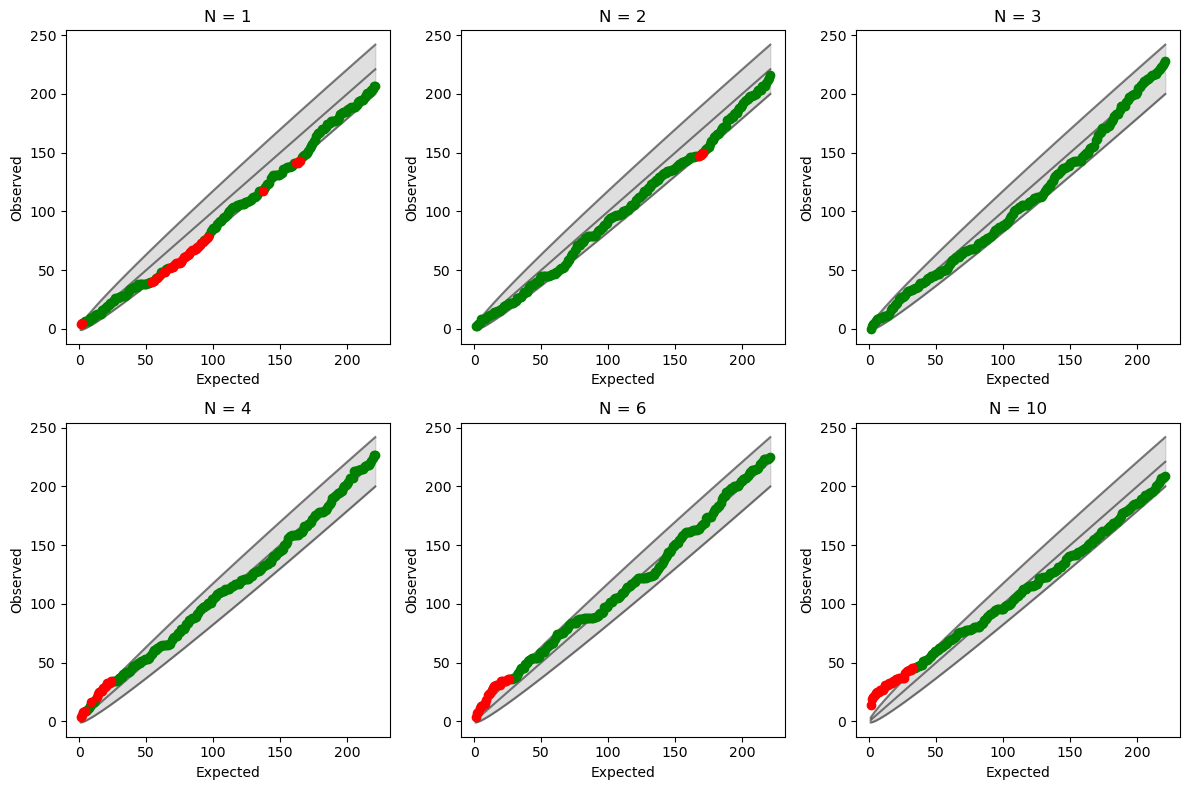

In [7]:
plot_extremes(X, upper_frac=0.5)

In [8]:
# 2-3 components looks ideal, so let's take this to be 3
model = PCA(
    n_components=3, 
    alpha=0.05, 
    gamma=0.01, 
    scale_x=True, # PCA always centers, but you can choose whether or not to scale the columns by st. dev. (autoscaling)
    robust="semi" # Estimate the degrees of freedom for the chi-squared acceptance area below using robust, data-driven approach
)

_ = model.fit(X)

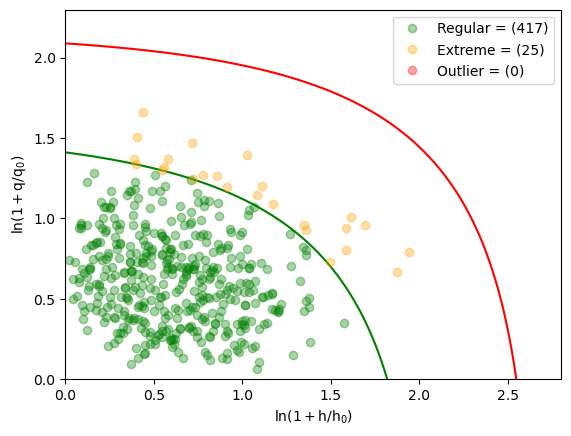

In [9]:
# Plot the chi-squared acceptance area with observations
# This will illustrate which points are considered "inliers", "extemes", and "outliers" given the chosen alpha and gamma.

_ = model.visualize(X)

In [10]:
# We can see which points are the extremes and outliers.
extremes_mask, outliers_mask = model.check_outliers(X)

In [11]:
# The predict method predicts which X are inliers.
inlier_mask = model.predict(X)

In [12]:
# The number of points outside the green boundary should be ~ alpha per cent of the data
1.0 - np.sum(inlier_mask) / X.shape[0]

0.0565610859728507

In [13]:
np.any(outliers_mask)

False

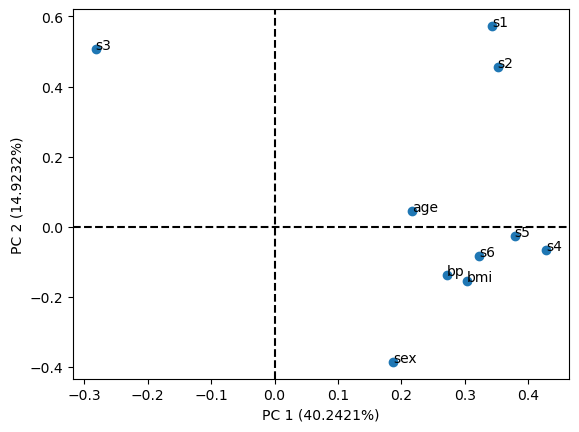

In [14]:
_ = model.plot_loadings(X.columns.values)

<h3>Outlier Removal</h3>

<div class="alert alert-block alert-warning">
For the sake of example, let's assume we chose the number of components to be too large, say 10.  Now we have outliers present. Using a technic known as <a href="https://doi.org/10.1021/acs.analchem.9b04611">sequential focused trimming</a> we can iteratively remove the outliers, retrain the model, and check again for outliers until we have a self-consistent set of data which predicts no more outliers.
</div>

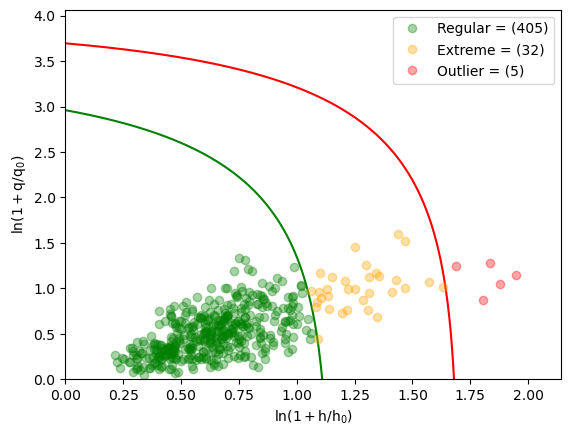

In [15]:
# What does the data look like at first?

model = PCA(
    n_components=10, 
    alpha=0.05, 
    gamma=0.01, 
    scale_x=True, # PCA always centers, but you can choose whether or not to scale the columns by st. dev. (autoscaling)
    robust="semi", # Estimate the degrees of freedom for the chi-squared acceptance area below using robust, data-driven approach
    sft=False
)

_ = model.fit(X)
_ = model.visualize(X)

In [16]:
# Now let's use SFT to remove outliers
model = PCA(
    n_components=10, 
    alpha=0.05, 
    gamma=0.01, 
    scale_x=True, # PCA always centers, but you can choose whether or not to scale the columns by st. dev. (autoscaling)
    robust="semi", # Estimate the degrees of freedom for the chi-squared acceptance area below using robust, data-driven approach
    sft=True
)
_ = model.fit(X)

print(
    '{} outer loop was performed; {} were initially removed, and {} returned'.format(
        model.sft_history['outer_loops'],
        len(model.sft_history['iterations'][1]['initially removed']),
        0 if model.sft_history['iterations'][1]['returned'] is None else len(model.sft_history['iterations'][1]['returned'])
    )
)

1 outer loop was performed; 11 were initially removed, and 0 returned


<div class="alert alert-block alert-info">
You can look at what was removed via `sft_history`.
</div>

In [17]:
X_net_removed = model.sft_history['removed']['X']

In [18]:
# 1. We can manually remove these from the original dataset.
X_saved = []
for row_1 in X.values:
    was_removed = False
    for row_2 in X_net_removed:
        if np.sum((row_1 - row_2)**2) < 1.0e-6:
            was_removed = True
            break
    if not was_removed:
        X_saved.append(row_1.tolist())
X_saved = np.array(X_saved)

In [19]:
# 2. Note that the PCA model stores the data it was trained on, so we can alternatively just access this private variable.
np.allclose(X_saved, model._PCA__X_)

True

<div class="alert alert-block alert-warning">
Note the acceptance plots look quite different from the one above.  Partly this is due to the removal of outliers, but also from the fact that `sft=True` uses robust methods until all outliers have been removed, then the final model is trained using classical methods. This also results in the fact that 1 of the points that have been removed as outlier (from a robustly trained model) <b>is actually an extreme</b> in the final model (classicly trained).
</div>

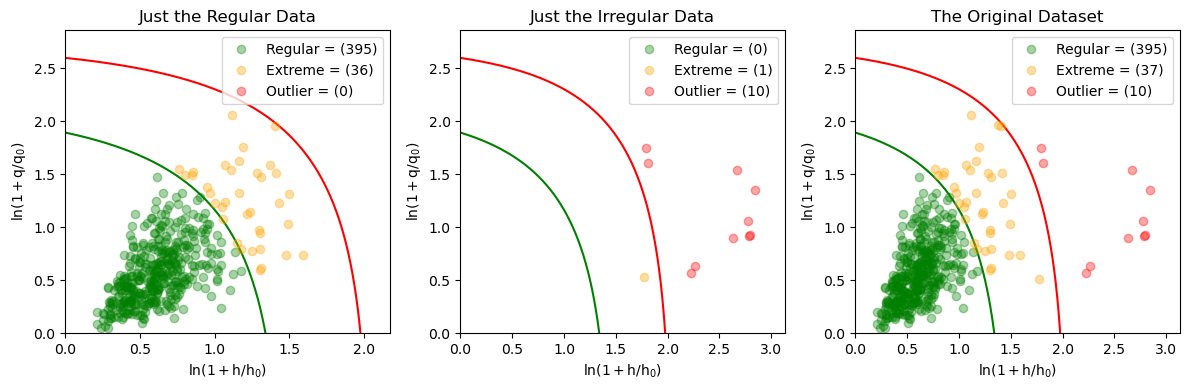

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
_ = model.visualize(X_saved, ax=axes[0])
_ = axes[0].set_title('Just the Regular Data')
_ = model.visualize(X_net_removed, ax=axes[1])
_ = axes[1].set_title('Just the Irregular Data')
_ = model.visualize(X, ax=axes[2])
_ = axes[2].set_title('The Original Dataset')
plt.tight_layout()

In [21]:
# For comparison, we can train a robust model from scratch (no sft) but only using the data used in the final loop.
robust_model = PCA(
    n_components=10, 
    alpha=0.05, 
    gamma=0.01, 
    scale_x=True, 
    robust="semi", 
    sft=False
)

# Only used the data used by the last loop in the sft=True model.
_ = robust_model.fit(X_saved)

<Axes: xlabel='${\\rm ln(1 + h/h_0)}$', ylabel='${\\rm ln(1 + q/q_0)}$'>

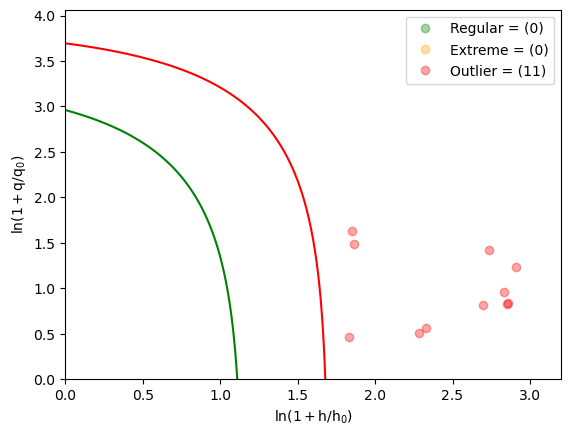

In [22]:
# It is clear that the robust model considers all those removed to be outliers.
robust_model.visualize(X_net_removed)

Model Multi-class Data with PCA
---

<div class="alert alert-block alert-info">
Let's look at a dataset meant for classification - here we probably want to consider each class individually.
</div>

In [23]:
from sklearn.datasets import load_wine as load_data
X, y = load_data(return_X_y=True, as_frame=True)

In [24]:
X.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


In [25]:
# Here we have 3 different classes of wine 
np.unique(y)

array([0, 1, 2])

In [26]:
X_0 = select_class(0, X, y)
X_1 = select_class(1, X, y)
X_2 = select_class(2, X, y)

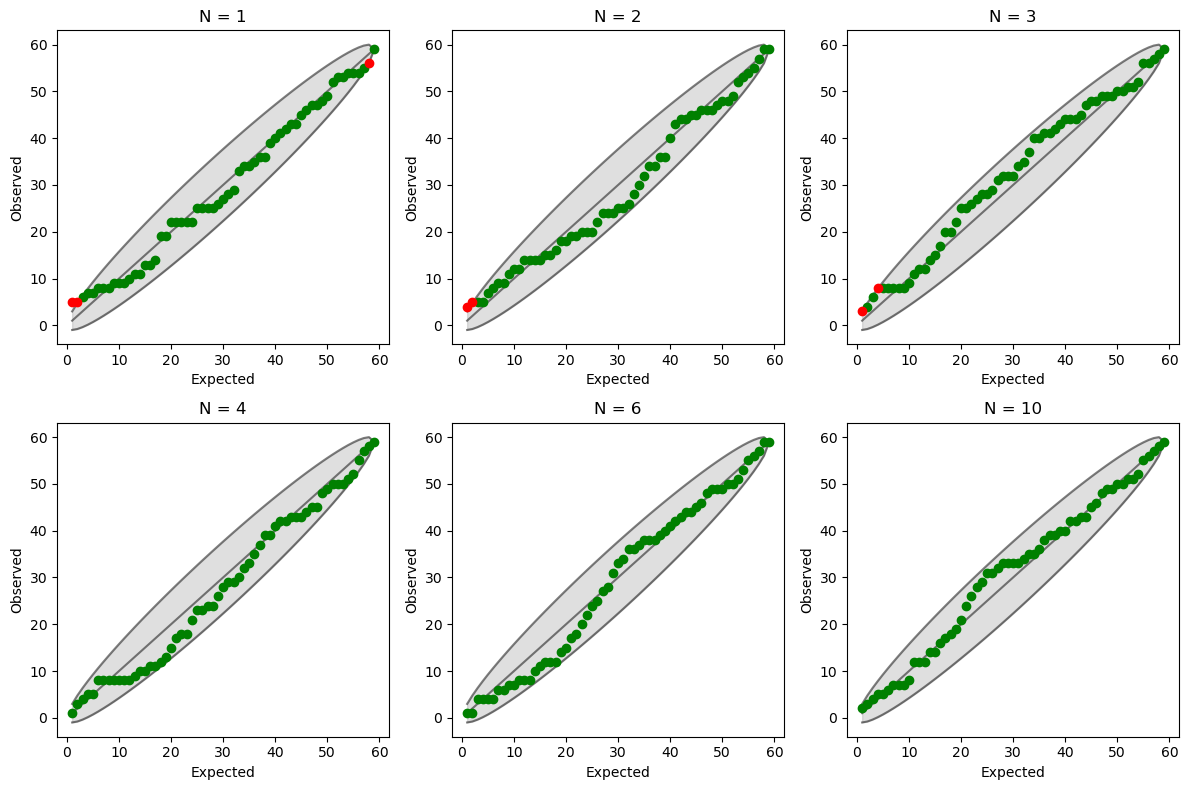

In [27]:
# If you build a PCA-based model for individual classes, like SIMCA, later on this can inform you about how many
# components might be helpful in modeling the data.
plot_extremes(X_0, upper_frac=1)

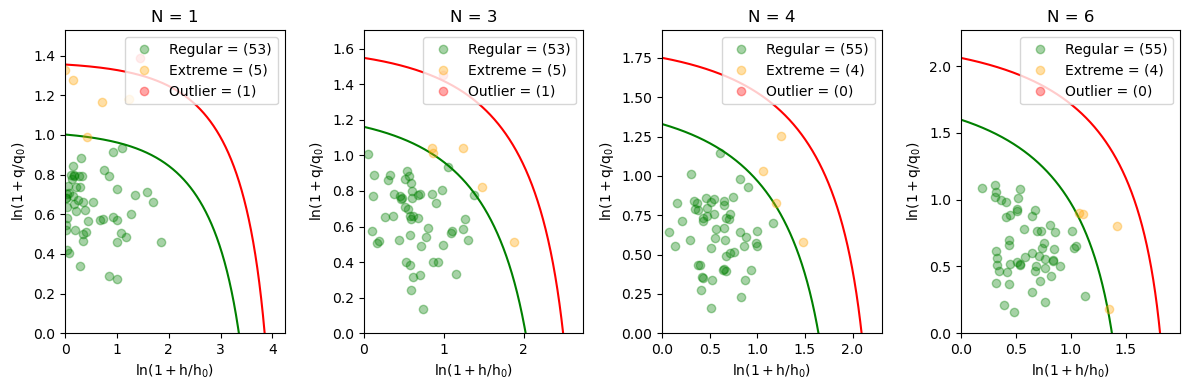

In [28]:
display_models([1, 3, 4, 6], X_0, figsize=(12,4))

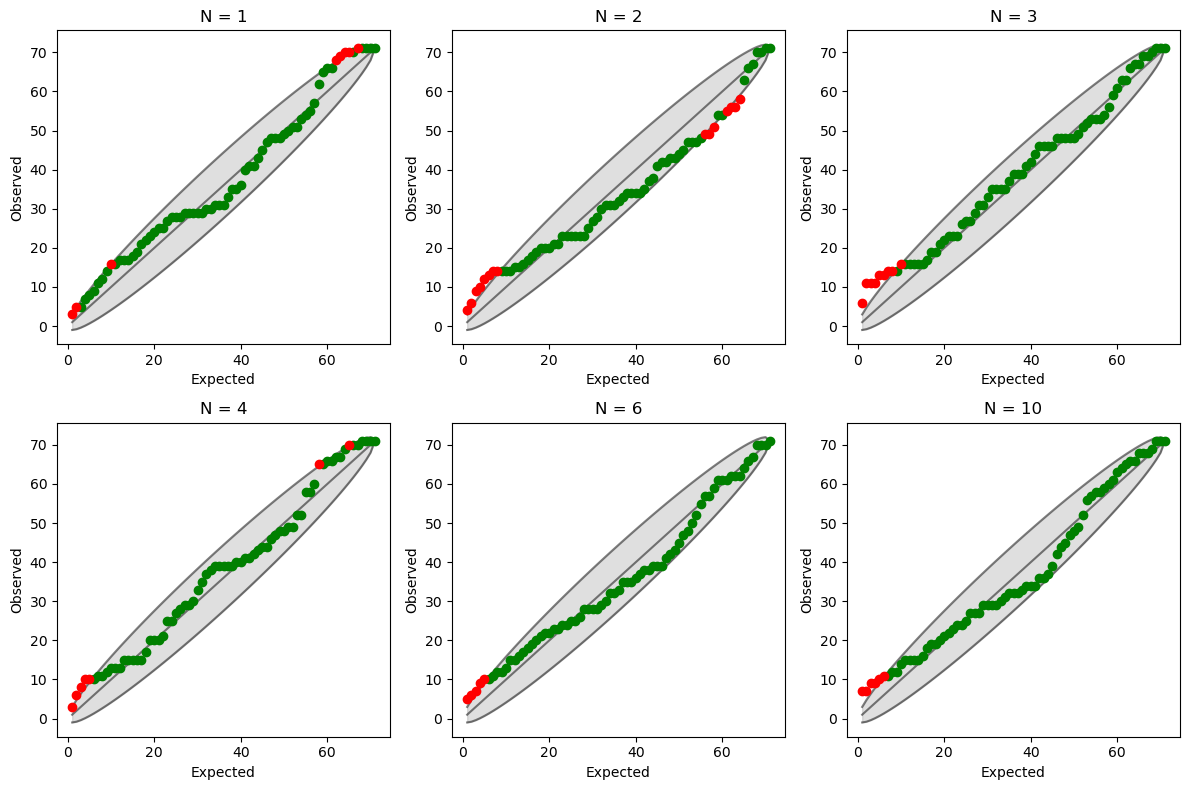

In [29]:
plot_extremes(X_1, upper_frac=1)

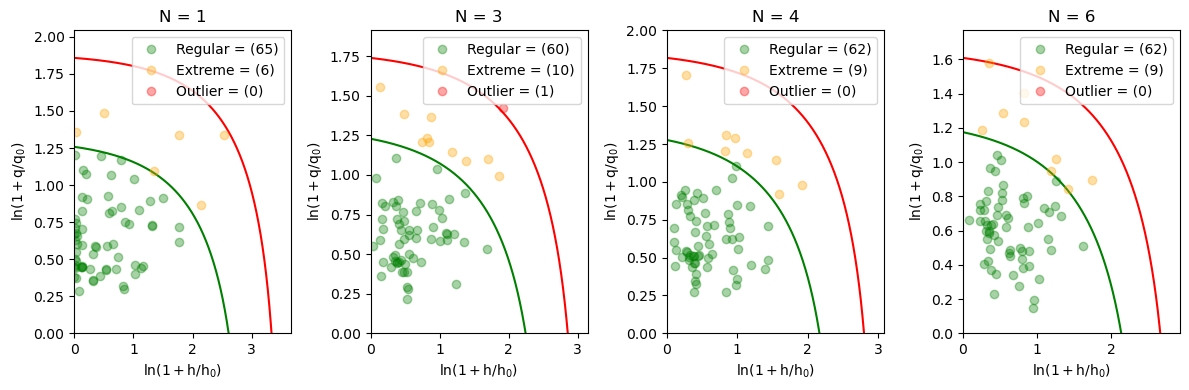

In [30]:
display_models([1, 3, 4, 6], X_1, figsize=(12,4))

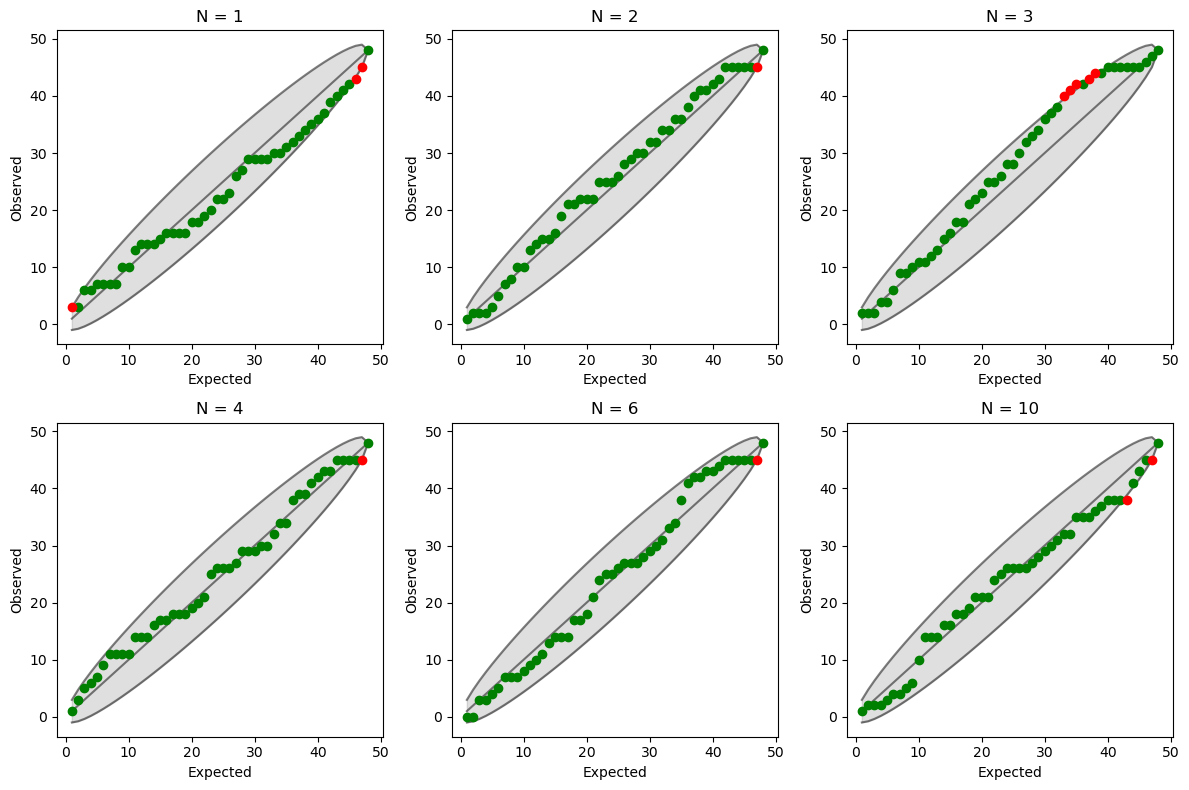

In [31]:
plot_extremes(X_2, upper_frac=1)

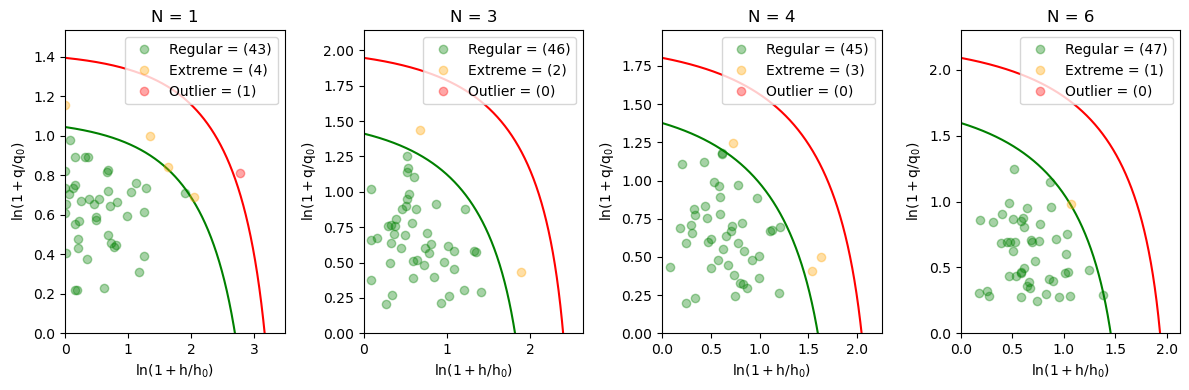

In [32]:
display_models([1, 3, 4, 6], X_2, figsize=(12,4))

In [33]:
.

SyntaxError: invalid syntax (1933637684.py, line 1)